In [7]:
import os
import imageio.v3 as iio
from skimage.measure import label
from skimage.morphology import medial_axis
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

In [2]:
ROOT = "/Users/gimli/cvr/data/beton/labels/cvat-antoine"

In [20]:
def compute_stats(file_path):
    segmented = iio.imread(file_path)[:,:,0] == 255
    labeled = label(segmented)
    
    bounds = []
    crack_images = []
    skeletons = []
    distances = []
    boundaries = []
    for l in range(1, np.max(labeled)):        
        crack = np.zeros(segmented.shape, dtype=int)
        crack[labeled == l] = 1    
        skeleton, distance = medial_axis(crack, return_distance=True)
        
        marked = mark_boundaries(segmented, crack, outline_color=(0.5,0,0),mode="outer")
        boundary = np.where(marked[:,:,0] == 0.5)
        bounds.append({
            "label": l,
            "size": np.sum(crack),
            "length": np.sum(skeleton),
            "maxWidth": np.max(distance),
            "avgWidth": np.mean(distance[distance != 0]),
            "boundaryLength": len(boundary[0])
        })

        skeletons.append((l, skeleton))
        distances.append((l, distance))
        boundaries.append((l, boundary))

        crack_image = np.stack([segmented, segmented, segmented], axis=2)
        crack_image[labeled==l, 0:2] = 0
        crack_images.append((l, crack_image))
    return labeled, skeletons, distances, boundaries, bounds, crack_images

In [21]:
stats = {}
for root, dirs, files in os.walk(ROOT):
    for file in files:
        if file.endswith(".png"):
            dir = root.split(os.path.sep)[-1]
            print(f"Processing {dir}-{file}")
            stats[f"{dir}-{file}"] = compute_stats(os.path.join(root, file))            

Processing 3A-after_1.png
Processing 3A-after_10.png
Processing 3A-after_11.png
Processing 3A-after_13.png
Processing 3A-after_12.png
Processing 1A-after_9.png
Processing 1A-before_4.png
Processing 1A-after_8.png
Processing 1A-after_5.png
Processing 1A-before_9.png
Processing 1A-after_4.png
Processing 1A-after_7.png
Processing 1A-after_2.png
Processing 1A-after_1.png
Processing 1A-after_10.png
Processing 1A-after_11.png
Processing 3C-before_1.png
Processing 3C-before_13.png
Processing 3C-after_1.png
Processing 3C-after_13.png
Processing 1B_bot-1B_bot_after00.png
Processing 1C-after_4.png
Processing 1C-after_3.png
Processing 1C-after_2.png
Processing 1C-after_1.png
Processing 1C-after_10.png
Processing 1C-after_11.png
Processing 1C-after_13.png
Processing 1C-after_12.png
Processing 1C-after_14.png


In [39]:
for stat_key in stats:    
    sample = stat_key.split("-")[0]
    scan = stat_key.split("-")[1][:-4]
    for crack_id, image in stats[stat_key][-1]:
        folder = os.path.join("/Users/gimli/Downloads/cracks-2/crack-maps", sample, scan)
        os.makedirs(folder, exist_ok=True)
        iio.imwrite(os.path.join("/Users/gimli/Downloads/cracks-2/crack-maps", sample, scan, f"{crack_id:03d}-crack.png"), 
                    cv2.cvtColor(image.astype(np.uint8)*255, cv2.COLOR_BGR2RGB))

In [35]:
import cv2

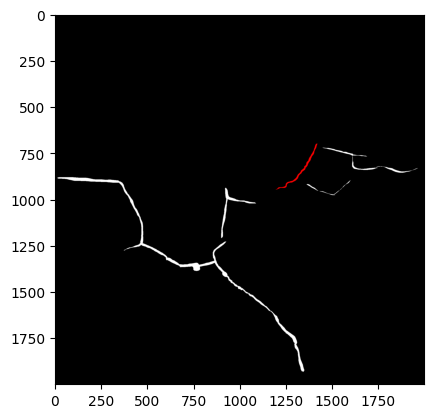

In [38]:
plt.imshow(cv2.cvtColor(stats["3A-after_1.png"][-1][0][1].astype(np.uint8)*255, cv2.COLOR_BGR2RGB))
plt.show()

In [18]:
import pandas as pd

,label,size,length,maxWidth,avgWidth,boundaryLength
0,1,2825,320,5.830952,2.457609,1902
1,2,2472,442,5.000000,2.063681,2042
2,3,1114,193,5.385165,2.319728,911
3,4,54,29,1.414214,1.038353,148
4,5,25912,2066,18.248288,3.701395,11194
5,6,168,62,2.236068,1.223011,381
6,7,359,64,3.605551,1.785735,405
7,8,4168,424,9.219544,3.097469,1984


In [20]:
for key in stats.keys():
    os.makedirs(os.path.join(ROOT, "stats"), exist_ok=True)
    pd.DataFrame(stats[key]).to_csv(f"{ROOT}/stats/{key.split('.')[0]}.csv")